<a href="https://colab.research.google.com/github/SW26010/Texture-Map-Toolbox/blob/main/luma_color_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

输入：一张彩色图像。

处理：
a. 首先，将输入图像转换为灰度图，得到每个像素的亮度值（0-255）。
ITU-R BT.709：Y = 0.2126R + 0.7152G + 0.0722B
b. 然后，遍历所有可能的灰度值（从0到255）。
c. 对于每一个灰度值 g，找到原始彩色图像中所有对应亮度为 g 的像素。
d. 计算这些找到的像素的RGB颜色值的平均值。

输出：一个宽度为256像素的颜色渐变条。这个渐变条的每一个水平位置（从左到右，0到255）的颜色，就是该灰度值对应的平均RGB颜色。

打印两张图象：

1.原始图像

2.灰度处理后再使用映射重新上色的图像

计算前后两个图像的mse

- 打开一张本地图像。

- 检查该图像是否有 Alpha 通道（透明度通道）。

- 如果图像没有 Alpha 通道，则为其添加一个完全不透明的 Alpha 通道。

- 将图像的 Alpha 通道进行二值化处理（即变为完全透明或完全不透明）。

- 将图像的颜色部分（RGB通道）根据 ITU-R BT.709 标准转换为灰度图。

In [ ]:
import numpy as np
from skimage import io, color
from skimage.util import img_as_float, img_as_ubyte
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
import matplotlib.pyplot as plt
import colour

# --- 1. 打开图像 ---
image_path = r"C:\Users\Himalia\OneDrive\Texture0\Kiriha14_PSD.png"
original_image = io.imread(image_path)

# 将图像转换为浮点数类型以便计算，范围在[0, 1]
rgb_float = img_as_float(original_image)[:, :, :3]
alpha_float = img_as_float(original_image)[:, :, 3] if original_image.shape[2] == 4 else np.ones_like(rgb_float[:, :, 0])
valid_mask = alpha_float > 0.5

# 根据ITU-R BT.709计算灰度图像
luma_float = color.rgb2gray(rgb_float)

- 遍历所有可能的灰度值。
- 对于每一个特定的灰度值 g，在之前生成的灰度图中找到所有值为 g 的像素位置。
- 根据这些位置，在原始的彩色图像中找到对应的像素。
- 计算这些被找到的彩色像素的R, G, B三个通道的平均值。

In [ ]:
# 使用掩码提取所有符合条件的像素的灰度值和RGB颜色
# valid_luma 是一维数组，包含了所有有效像素的灰度值
# valid_rgb 是二维数组，形状为(N, 3)，N是有效像素的数量

valid_luma_pixel_int = img_as_ubyte(luma_float)[valid_mask]
valid_rgb_pixel_float = rgb_float[valid_mask]

# 统计每个灰度值的数量
luma_histogram = np.bincount(valid_luma_pixel_int, minlength=256)

# --- 任务2: 计算每个灰度值对应的平均颜色 ---

# valid_rgb_pixel_float.T 会将数组转置为 (3, N) 的形状，
# 这样我们就可以在列表推导式中直接遍历 R, G, B 三个通道的权重数组
rgb_sums_by_luma = np.stack(
    [np.bincount(valid_luma_pixel_int, weights=channel_values, minlength=256) for channel_values in valid_rgb_pixel_float.T],
    axis=1
)

'''
# 备选方案，效率较低
rgb_sums_by_luma = np.zeros((256, 3), dtype=np.float64)
np.add.at(rgb_sums_by_luma, valid_luma_pixel_int, valid_rgb_pixel_float)
'''

# c. 计算平均值
with np.errstate(divide='ignore', invalid='ignore'):
    luma_to_rgb_map_float = rgb_sums_by_luma / luma_histogram[:, np.newaxis]

# TODO：or use luma_to_rgb_map_float = rgb_sums_by_luma / (luma_histogram[:, np.newaxis] + 1e-6)？

'''
# 更健壮的除法
counts_reshaped = luma_histogram[:, np.newaxis] # 变形以利用广播机制
luma_to_rgb_map_float = np.divide(
    rgb_sums_by_luma,
    counts_reshaped,
    out=np.full((256, 3), np.nan, dtype=np.float32), # 预设输出，无效值将为nan
    where=counts_reshaped != 0 # 只在计数值不为0的地方执行除法
)
'''
# luma_to_rgb_map_float 数组的索引 i 对应灰度值 i 的平均RGB颜色
# 如果某个灰度值没有出现在有效像素中，则其对应的颜色值为 [nan, nan, nan]

luma_to_hsl_map_float = colour.RGB_to_HSL(luma_to_rgb_map_float)
# luma_to_hsl_map_float = color.rgb2hsl(luma_to_rgb_map_float)本来一行代码就能解决，但是skimage没有这个函数

In [ ]:
luma_to_hsl_map_float[np.isnan(luma_to_hsl_map_float).any(axis=1)] = np.nan

- 生成新图像：根据原图的灰度值，从这个LUT中查找对应的平均颜色，从而生成一张新的彩色图像。

In [ ]:
recolored_rgb_float = luma_to_rgb_map_float[img_as_ubyte(luma_float)]
recolored_rgb_int = img_as_ubyte(recolored_rgb_float)

psnr = peak_signal_noise_ratio(original_image[:, :, :3][valid_mask], recolored_rgb_int[valid_mask])

# 注意：这里使用量化后的图像进行比较，以模拟实际应用中8-bit精度损失带来的影响
delta_e_image = colour.difference.delta_E_CIE2000(
    colour.XYZ_to_Lab(colour.sRGB_to_XYZ(img_as_float(recolored_rgb_int))),
    colour.XYZ_to_Lab(colour.sRGB_to_XYZ(rgb_float))
)
# TODO: 这里的计算delta_e_image似乎没有考虑valid_mask

In [ ]:
# --- 任务3: 使用valid_mask处理delta_e_image，并计算平均delta E ---

# 使用掩码提取所有有效像素的 Delta E 值
valid_delta_e = delta_e_image[valid_mask]

# 计算色差的各项统计学特征
delta_e_stats = {
    'mean': np.mean(valid_delta_e),
    'median': np.median(valid_delta_e),
    'std_dev': np.std(valid_delta_e),
    'max': np.max(valid_delta_e),
    '95th_percentile': np.percentile(valid_delta_e, 95)
}

print(f"PSNR (Peak Signal-to-Noise Ratio): {psnr:.2f} dB")
for key, value in delta_e_stats.items():
    print(f"Delta E 2000 ({key.replace('_', ' ').title()}): {value:.2f}")

PSNR (Peak Signal-to-Noise Ratio): 62.86 dB
Delta E 2000 (Mean): 0.03
Delta E 2000 (Median): 0.00
Delta E 2000 (Std Dev): 0.12
Delta E 2000 (Max): 0.80
Delta E 2000 (95Th Percentile): 0.40


- 可视化结果

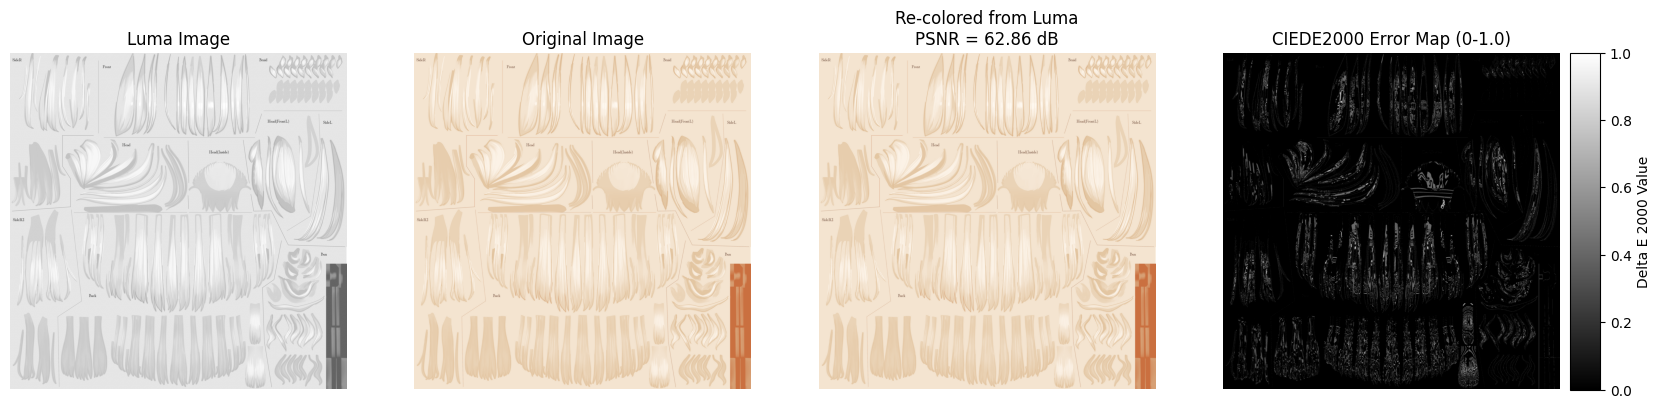

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 80))

# 预览灰度图像（透明处置为黑色）
ax[0].imshow(np.where(valid_mask, luma_float, 0.0), cmap='gray')
ax[0].set_title('Luma Image')

# 原始图像
ax[1].imshow(original_image)
ax[1].set_title('Original Image')

# 重建后的图像（采用8bit量化）
ax[2].imshow(np.where(valid_mask[..., np.newaxis], recolored_rgb_int, 0))
ax[2].set_title(f'Re-colored from Luma\nPSNR = {psnr:.2f} dB')

# CIEDE2000
DELTA_E_MAX = 1.0
delta_e_clipped = np.clip(delta_e_image, 0.0, DELTA_E_MAX)
im_de = ax[3].imshow(
    np.where(valid_mask, delta_e_clipped, 0.0),
    cmap='gray',
    vmin=0.0,
    vmax=DELTA_E_MAX
)
ax[3].set_title(f'CIEDE2000 Error Map (0-{DELTA_E_MAX})')
#在 ax[3] 的右侧创建一个新的 Axes 用于放置 colorbar
pos3 = ax[3].get_position()
cax = fig.add_axes([pos3.x1 + 0.005, pos3.y0, 0.015, pos3.height])
cbar = fig.colorbar(im_de, cax=cax)
cbar.set_label('Delta E 2000 Value')

# 统一关闭所有子图的坐标轴
for a in ax:
    a.axis('off')
plt.show()

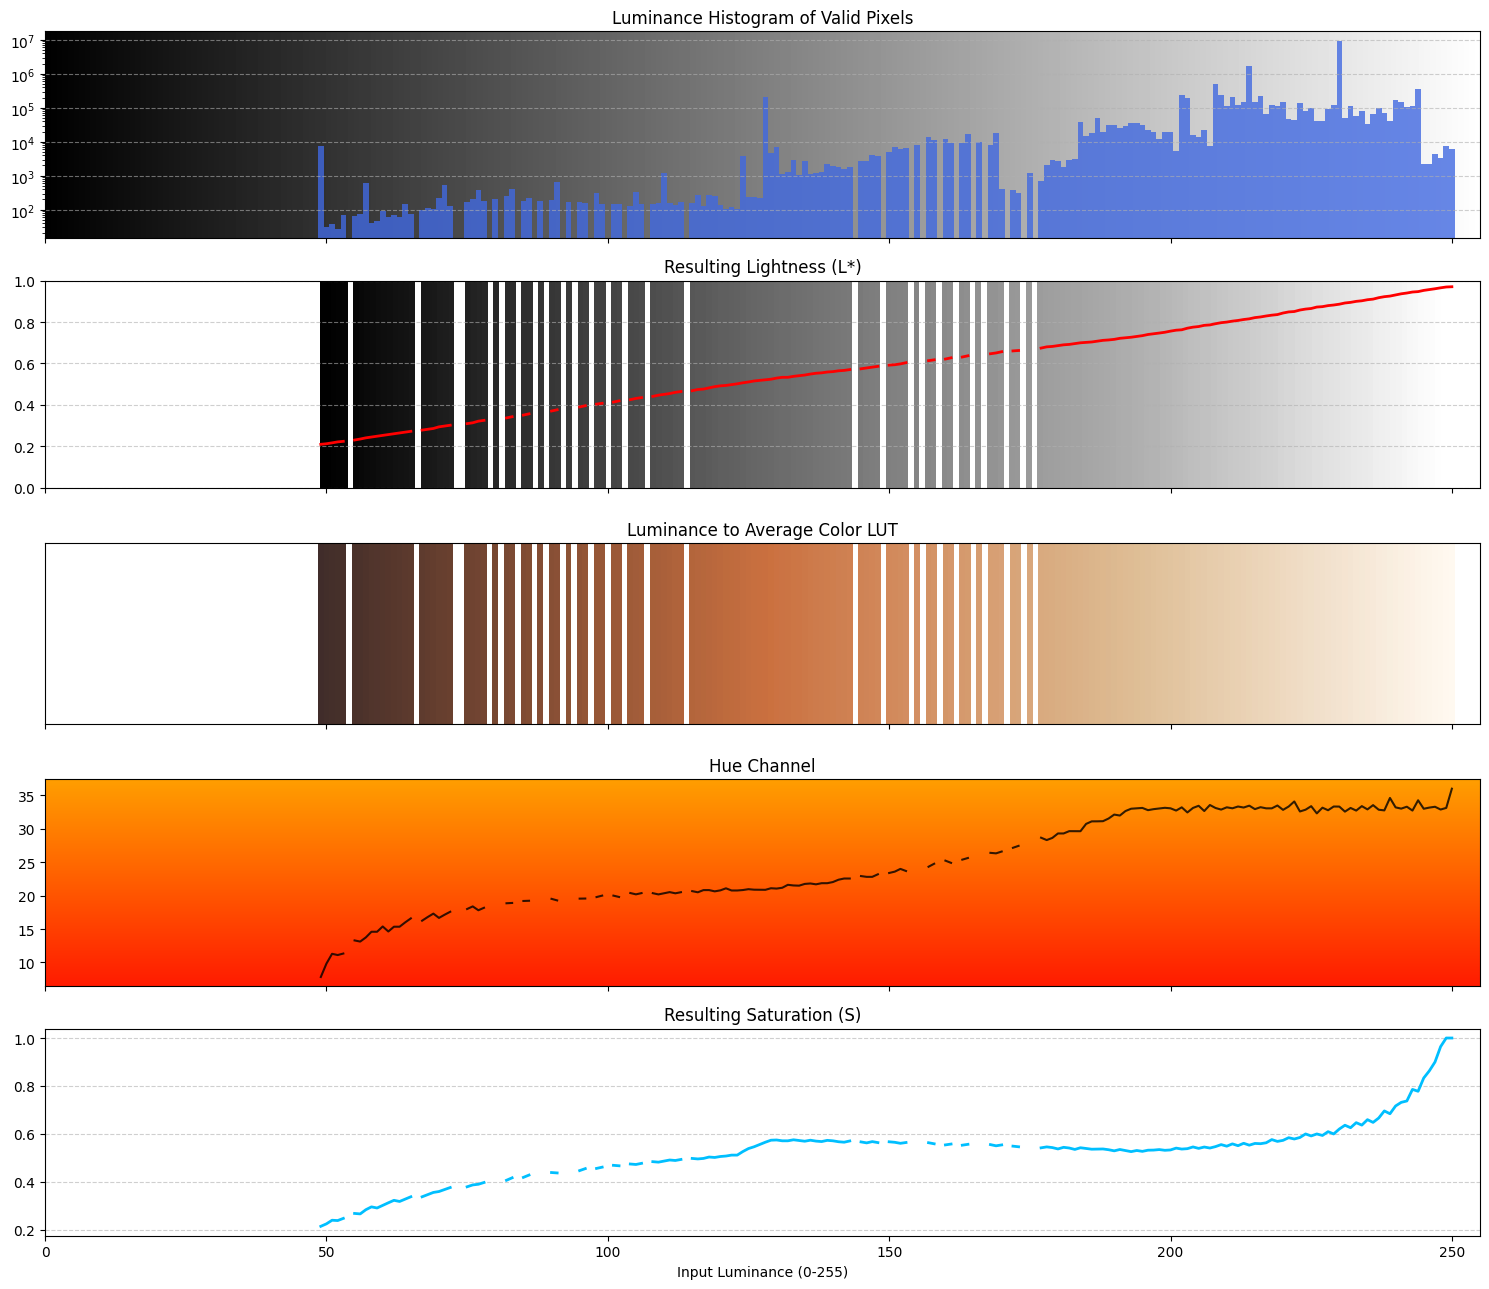

In [ ]:
fig, ax = plt.subplots(5, 1, figsize=(15, 13), sharex=True)


# 1. 亮度像素分布直方图
ax[0].bar(np.arange(256), luma_histogram, width=1.0, color='royalblue', alpha=0.8)
ax[0].set_yscale('log')
y_min, y_max = ax[0].get_ylim()
ax[0].imshow(np.linspace(0, 1, 256).reshape(1, 256), cmap='gray', aspect='auto', extent=[0, 255, y_min, y_max])
ax[0].set_title('Luminance Histogram of Valid Pixels')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)
ax[0].set_xlim(0, 255)


# 2. 原始亮度 -> 平均色亮度(L*) 的关系图
l_channel = luma_to_hsl_map_float[:, 2]
ax[1].plot(np.arange(256), l_channel, color='red', linewidth=2)
ax[1].set_ylim(0, 1)
y_min, y_max = ax[1].get_ylim()
ax[1].imshow(l_channel.reshape(1, 256), cmap='gray', aspect='auto', extent=[0, 255, y_min, y_max])
ax[1].grid(axis='y', linestyle='--', alpha=0.6)
ax[1].set_title('Resulting Lightness (L*)')


# 3. 亮度 -> 平均色 的查找表(LUT)可视化
ax[2].imshow(np.broadcast_to(luma_to_rgb_map_float, (32, 256, 3)))
ax[2].set_title('Luminance to Average Color LUT')
ax[2].set_yticks([])




# 4. 显示luma_to_hsl_map_float的h色度图，以l=0.5，s=1为背景，叠加h的图线，值从归一化浮点映射到0-360，纵坐标显示范围自适应

h_channel = luma_to_hsl_map_float[:, 0] * 360 # 转换为角度 0-360
ax[3].plot(np.arange(256), h_channel, color='black', linewidth=1.5, alpha=0.8)
ymin, ymax = ax[3].get_ylim()

# 1. 定义图像尺寸和数据类型
height, width = 360, 255
dtype = np.float64

# 2. 创建一个空的 HSL 图像数组
# 数组形状为 (高, 宽, 3)，3个通道分别对应 H, S, L
hue_gradient_hsl = np.zeros((height, width, 3), dtype=dtype)
hue_gradient_hsl[..., 0] = np.linspace(ymin/360, ymax/360, height, dtype=dtype)[:, np.newaxis]# 注意坐标和h过渡的方向对应
hue_gradient_hsl[..., 1] = 1.0
hue_gradient_hsl[..., 2] = 0.5

# 4. 将 HSL 图像转换为 RGB 图像
hue_gradient_rgb = colour.HSL_to_RGB(hue_gradient_hsl)

# 将这个图片作为背景，但要适应plot的纵坐标范围，随之裁剪，而且推测要改变像素长宽比例
ax[3].imshow(hue_gradient_rgb, origin='lower', aspect='auto', extent=[0, 255, ymin, ymax])

ax[3].set_title("Hue Channel")


# 5. luma_to_hsl_map_float的s饱和度图线
# 假设 luma_to_hsl_map_float 的第二列是 Saturation
s_channel = luma_to_hsl_map_float[:, 1]

# 叠加饱和度曲线
ax[4].plot(np.arange(256), s_channel, color='deepskyblue', linewidth=2)
ax[4].set_title('Resulting Saturation (S)')
ax[4].grid(axis='y', linestyle='--', alpha=0.6)
ax[4].set_xlabel('Input Luminance (0-255)') # 为共享的X轴添加总标签

# 调整子图间的间距，防止标题重叠
plt.tight_layout()

plt.show()